In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os



import tensorflow as tf

2025-06-17 07:04:39.840374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750169079.859328 1479790 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750169079.864471 1479790 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750169079.904022 1479790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750169079.904229 1479790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750169079.904232 1479790 computation_placer.cc:177] computation placer alr

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
Built with CUDA: True
Built with GPU support: True
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.19.0
Num GPUs Available:  1


In [5]:
current_directory = os.getcwd()
print(current_directory)

/global/u2/k/kberard/SCGSR/Research/Diamond/Testing


In [6]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [7]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_vmc_samples_1024_0005160960.h5', 'r') as file:
    print("Keys: %s" % file.keys())
    tot_VMC_d = file['density'][:]
#print(ref_d)
print(tot_VMC_d.shape)
minorized_tot_VMC_d = (np.sum(tot_VMC_d,axis=2))
minorized_tot_VMC_d.shape

Keys: <KeysViewHDF5 ['axes', 'centered', 'density', 'density_data_type', 'density_type', 'folding', 'grid', 'nelec', 'points', 'stochastic_type', 'tiling', 'weights']>
(1024, 64, 64, 64)


(1024, 64, 64)

In [8]:
x_test = minorized_tot_VMC_d[900:]
print(x_test.shape)
train_val = minorized_tot_VMC_d[:900]
print(train_val.shape)
sample_mean_ref = np.mean(train_val, axis=0)
print(sample_mean_ref.shape)

(124, 64, 64)
(900, 64, 64)
(64, 64)


In [9]:
from sklearn.model_selection import train_test_split
x_train,x_val = train_test_split(train_val, test_size=.15, train_size=.85, random_state=42, shuffle=True)

In [10]:
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

(124, 64, 64)
(765, 64, 64)
(135, 64, 64)


In [11]:
y_test = np.zeros((x_test.shape))
y_train = np.zeros((x_train.shape))
y_val = np.zeros((x_val.shape))

for i in range (y_test.shape[0]):
    y_test[i]=sample_mean_ref

for i in range (y_train.shape[0]):
    y_train[i]=sample_mean_ref

for i in range (y_val.shape[0]):
    y_val[i]=sample_mean_ref

# to use DFT ref
"""for i in range (y_test.shape[0]):
    y_test[i]=minorized_ref_d

for i in range (y_train.shape[0]):
    y_train[i]=minorized_ref_d

for i in range (y_val.shape[0]):
    y_val[i]=minorized_ref_d"""

'for i in range (y_test.shape[0]):\n    y_test[i]=minorized_ref_d\n\nfor i in range (y_train.shape[0]):\n    y_train[i]=minorized_ref_d\n\nfor i in range (y_val.shape[0]):\n    y_val[i]=minorized_ref_d'

In [15]:
# Add channel dimension
x_train = x_train[..., np.newaxis]
x_val   = x_val[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val   = y_val[..., np.newaxis]
y_test   = y_test[..., np.newaxis]

In [12]:
# another way of computing JS
"""from scipy.spatial import distance
def jensen_shannon_divergence(P, Q):
    print(P,Q)
    print(type(P))
    P = P.flatten()
    Q = Q.flatten()
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return (distance.jensenshannon(P,Q))**2"""

'from scipy.spatial import distance\ndef jensen_shannon_divergence(P, Q):\n    print(P,Q)\n    print(type(P))\n    P = P.flatten()\n    Q = Q.flatten()\n    P = P / np.sum(P)\n    Q = Q / np.sum(Q)\n    return (distance.jensenshannon(P,Q))**2'

In [17]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


I0000 00:00:1750162739.748794 2251991 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34363 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/100


I0000 00:00:1750162743.357331   65100 service.cc:152] XLA service 0x7fb3d800cb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750162743.357682   65100 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-06-17 05:19:03.433094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750162743.746686   65100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 41/153 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474  

I0000 00:00:1750162746.977592   65100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0349 - val_loss: 1.9859e-04
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1911e-04 - val_loss: 2.7168e-05
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0553e-05 - val_loss: 8.9497e-06
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3315e-06 - val_loss: 4.0456e-06
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4531e-06 - val_loss: 2.1120e-06
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8525e-06 - val_loss: 1.2483e-06
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1104e-06 - val_loss: 7.7256e-07
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9460e-07 - val_loss: 5.0470e-07
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6184e-07 - val_loss: 3.5338e-07
Epoch 10/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2482e-07 - val_loss: 2.5266e-07
Epoch 11/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.

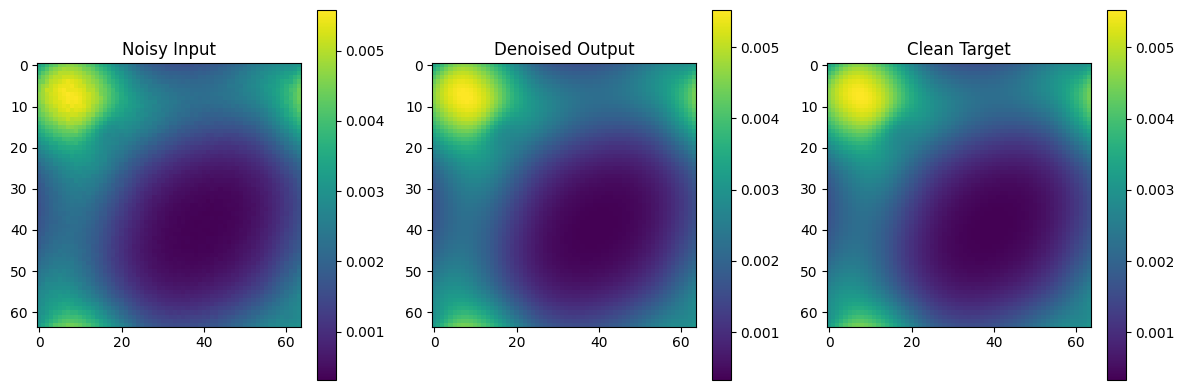

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt



# --- DAE Definition with Channel Dimension Support ---
def create_dae(input_shape):
    def renormalize(x):
        x_sum = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
        x = x / (x_sum + 1e-8) * 8.0
        return x
    flat_dim = np.prod(input_shape)
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        # Encoder
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        
        # Decoder
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(flat_dim, activation='sigmoid'),
        layers.Reshape(target_shape=input_shape),
        layers.Lambda(renormalize)
    ])
    return model

# --- Main Execution ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)


    dae = create_dae(input_shape)
    # change loss to JS div
    dae.compile(optimizer='adam', loss=jensen_shannon_divergence_loss)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=5,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and Evaluate ---
    i = 0
    denoised_norm = dae.predict(x_test[i:i+1])[0, ..., 0]
    denoised = denoised_norm
    noisy_input = x_test[i, ..., 0]
    true_clean = y_test

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input, cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean[0,:,:,0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    
    

In [15]:
# norm check after denosing and check that the norm of the denormalized y is the same as the refernce 
print(np.linalg.norm(denoised-true_clean[0,:,:,0]))
print(np.linalg.norm(true_clean[0,:,:,0]))
print(np.linalg.norm(denoised-minorized_ref_d))

#print(true_clean)
print(np.linalg.norm(y_test[0]))

0.00018603075729815274
0.1465650367842726
0.00018897609022625796
0.1465650367842726


In [16]:
print(denoised)


[[0.00336325 0.00360994 0.00388201 ... 0.00295713 0.00303012 0.00316455]
 [0.00361107 0.00387596 0.00415099 ... 0.00311211 0.00321911 0.00338715]
 [0.00387982 0.00415024 0.00441452 ... 0.00330125 0.00344222 0.00363792]
 ...
 [0.00295578 0.00311345 0.00330085 ... 0.00271778 0.00276567 0.00284225]
 [0.00303053 0.00321949 0.00344136 ... 0.00276501 0.00281069 0.0028947 ]
 [0.00316348 0.00338725 0.00363907 ... 0.00284276 0.00289351 0.00299824]]


In [17]:
print(true_clean[0,:,:,0])

[[0.00335897 0.00360506 0.0038763  ... 0.00295437 0.00302717 0.00316067]
 [0.003606   0.00387001 0.00414452 ... 0.00310887 0.00321549 0.00338272]
 [0.00387392 0.00414361 0.00440738 ... 0.00329717 0.00343779 0.00363266]
 ...
 [0.00295282 0.00311034 0.00329691 ... 0.00271579 0.00276383 0.00284006]
 [0.0030275  0.00321572 0.00343687 ... 0.00276296 0.00280839 0.00289216]
 [0.00315997 0.00338295 0.00363385 ... 0.00284034 0.00289105 0.00299542]]


In [18]:
# check norm before denoising 
print(x_test[0,:,:,0])
print(np.linalg.norm(x_test[0,:,:,0])-np.linalg.norm(true_clean[0,:,:,0]))

[[0.00336817 0.00359332 0.00387409 ... 0.00295352 0.00304323 0.00310214]
 [0.00363091 0.00386033 0.00415078 ... 0.00308644 0.0031901  0.00339762]
 [0.00384037 0.00419592 0.00442088 ... 0.00329687 0.00341836 0.00364176]
 ...
 [0.00296766 0.00313701 0.00330249 ... 0.00267179 0.00276092 0.00281963]
 [0.00304827 0.00318332 0.00342785 ... 0.00277196 0.00280762 0.00284773]
 [0.00313643 0.00340111 0.00362394 ... 0.00288958 0.00290256 0.00295895]]
1.3356941478415152e-05


In [19]:
print(x_test.shape)

(124, 64, 64, 1)


In [20]:

y_dft = np.zeros((len(x_test),64,64))

for i in range (y_dft.shape[0]):
    y_dft[i]=minorized_ref_d
print(y_dft.shape)
#check divergence of denoised vs not denoised matrix
print("DAE JSD (denoised vs. clean):", jensen_shannon_divergence_loss(dae.predict(x_test.copy()), y_test.copy()))
print("DAE JSD (noise vs. clean):", jensen_shannon_divergence_loss(x_test.copy(), y_test.copy()))
print("DAE JSD (denoised vs. dft):", jensen_shannon_divergence_loss(dae.predict(x_test.copy()), y_dft.copy()))
print("mean:", jensen_shannon_divergence_loss(np.mean(x_test.copy(),axis=0), y_dft[0].copy()))
print()
print("DAE JSD (denoised vs. dft):", jensen_shannon_divergence_loss(np.mean(dae.predict(x_test.copy()),
                                                                            axis=0), y_dft[0].copy()))
print()
mean_pred = dae.predict(np.mean(x_test.copy(),axis=0).reshape(1,64,64,1))

                        
print("mean_out:", jensen_shannon_divergence_loss(np.squeeze(mean_pred), y_dft[0].copy()))


(124, 64, 64)
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step
DAE JSD (denoised vs. clean): tf.Tensor(2.363832e-09, shape=(), dtype=float32)
DAE JSD (noise vs. clean): tf.Tensor(1.3202337e-05, shape=(), dtype=float32)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
DAE JSD (denoised vs. dft): tf.Tensor(1.6362339e-08, shape=(), dtype=float32)
mean: tf.Tensor(1.232427e-07, shape=(), dtype=float32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
DAE JSD (denoised vs. dft): tf.Tensor(1.7751711e-08, shape=(), dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
mean_out: tf.Tensor(3.047348e-07, shape=(), dtype=float32)


In [21]:
#nooise vs dft
# denoised vs dft
print("mean:", jensen_shannon_divergence_loss(np.mean(x_test.copy(),axis=0), y_dft[0].copy()))
print("DAE JSD (noise vs. dft):", jensen_shannon_divergence_loss(x_test.copy(), y_dft.copy()))
print("DAE JSD (denoised vs. dft):", jensen_shannon_divergence_loss(dae.predict(x_test.copy()), y_dft.copy()))


mean: tf.Tensor(1.232427e-07, shape=(), dtype=float32)
DAE JSD (noise vs. dft): tf.Tensor(1.3187233e-05, shape=(), dtype=float32)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
DAE JSD (denoised vs. dft): tf.Tensor(1.6362339e-08, shape=(), dtype=float32)


In [22]:
a = .35
x_m = np.squeeze(np.mean(x_test.copy(),axis=0))
print(x_m.shape)
print(y_dft[0].shape)
print("mean:", jensen_shannon_divergence_loss(a*x_m+(1-a)*y_dft[0], y_dft[0].copy()))
#print("mean:", jensen_shannon_divergence_loss((1-a)*np.mean(x_test.copy(),axis=0)+a*y_dft[0].copy(), y_dft[0].copy()))
print(1/a**2)

(64, 64)
(64, 64)
mean: tf.Tensor(1.5119305e-08, shape=(), dtype=float32)
8.163265306122451


In [23]:
#check the number of electrons
# need to ensure this is kept true throught taining
print("number of electron is should = 8",np.sum(denoised.sum(axis=1)))


number of electron is should = 8 8.0


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0997 - val_loss: 0.0325
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0305 - val_loss: 0.0079
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 8.2352e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2966e-04 - val_loss: 5.8616e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6981e-04 - val_loss: 5.3128e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2253e-04 - val_loss: 5.0066e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9559e-04 - val_loss: 4.8176e-04
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7798e-04 - val_loss: 4.6721e-04
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6403e-04 - val_loss: 4.5490e-04
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5211e-04 - val_loss: 4.4395e-04
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4141e-04 - val_loss: 4.

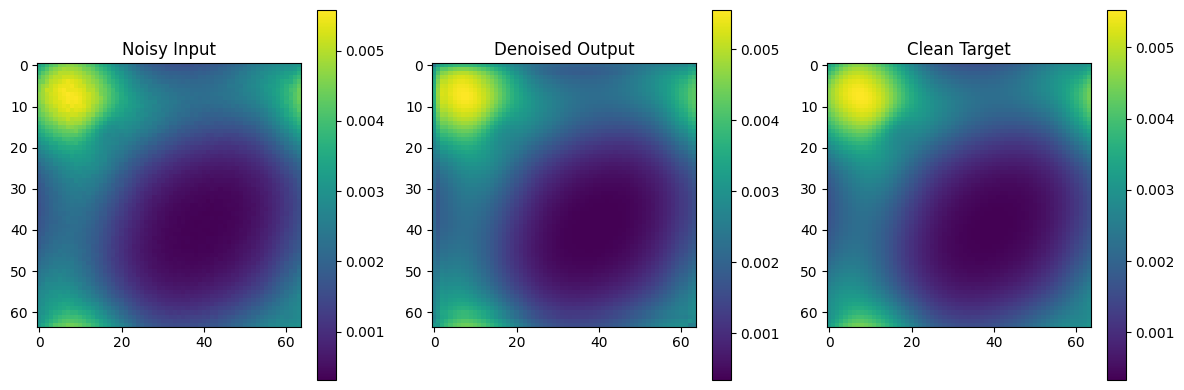

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt



def create_cae(input_shape, target_sum=8.0):
    input_layer = layers.Input(shape=input_shape)
    # Renormalize output to have a fixed sum (e.g., 8 electrons)
    def renormalize(x):
        x_sum = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
        return x / (x_sum + 1e-8) * target_sum
    # Encoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    #x = layers.Lambda(renormalize)(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    #x = layers.Lambda(renormalize)(x)

    # Decoder
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    #x = layers.Lambda(renormalize)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    #x = layers.Lambda(renormalize)(x)
    x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)  # use relu to ensure non-negativity



    output_layer = layers.Lambda(renormalize)(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# --- Main ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)  # CAE expects 4D shape with channel

    # Create model
    cae = create_cae(input_shape)
    cae.compile(optimizer='adam', loss=jensen_shannon_divergence_loss)



    # --- Early stopping ---
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # --- Train ---
    cae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=20,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and plot ---
    i = 0  # test sample index
    denoised_norm = cae.predict(x_test[i:i+1])[0, ..., 0]
    denoised = denoised_norm

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i, ..., 0], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(y_test[0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()



In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

x_train_t = torch.tensor(x_train.copy(), dtype=torch.float32).permute(0, 3, 1, 2)
y_train_t = torch.tensor(y_train.copy(), dtype=torch.float32).permute(0, 3, 1, 2)
x_val_t = torch.tensor(x_val.copy(), dtype=torch.float32).permute(0, 3, 1, 2)
y_val_t = torch.tensor(y_val.copy(), dtype=torch.float32).permute(0, 3, 1, 2)
x_test_t = torch.tensor(x_test.copy(), dtype=torch.float32).permute(0, 3, 1, 2)
y_test_t = torch.tensor(y_test.copy(), dtype=torch.float32).permute(0, 3, 1, 2)


# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-8, 1.0)
    y_true = torch.clamp(y_true, 1e-8, 1.0)
    print(y_pred.shape,y_true.shape)
    m = 0.5 * (y_pred + y_true)
    kl1 = torch.sum(y_true * torch.log(y_true / m), dim=(1, 2, 3))
    kl2 = torch.sum(y_pred * torch.log(y_pred / m), dim=(1, 2, 3))
    return 0.5 * (kl1 + kl2).mean()

# --- CAE with Circular Padding ---
class CAE(nn.Module):
    def __init__(self, input_channels=1, target_sum=8.0):
        super(CAE, self).__init__()
        self.target_sum = target_sum

        self.enc1 = nn.Conv2d(input_channels, 16, kernel_size=3,stride=1, padding='same', padding_mode='circular')
        self.enc2 = nn.Conv2d(16, 8, kernel_size=3,stride=1, padding='same', padding_mode='circular')
        self.dec1 = nn.Conv2d(8, 8, kernel_size=3,stride=1, padding='same', padding_mode='circular')
        self.dec2 = nn.Conv2d(8, 16, kernel_size=3,stride=1, padding='same', padding_mode='circular')
        self.dec3 = nn.Conv2d(16, 1, kernel_size=3,stride=1, padding='same', padding_mode='circular')

    def circular_pad(self, x, pad=1):
        return F.pad(x, (pad, pad, pad, pad), mode='circular')

    def renormalize(self, x):
        x_sum = x.sum(dim=(1, 2, 3), keepdim=True) + 1e-8
        return x / x_sum * self.target_sum

    def forward(self, x):
        x = self.circular_pad(x, pad=1)
        x = F.relu(self.enc1(x))

        x = self.circular_pad(x, pad=1)
        x = F.relu(self.enc2(x))

        x = self.circular_pad(x, pad=1)
        x = F.relu(self.dec1(x))

        x = self.circular_pad(x, pad=1)
        x = F.relu(self.dec2(x))

        x = self.circular_pad(x, pad=1)
        x = F.relu(self.dec3(x))

        return self.renormalize(x)


# --- Data Loaders ---
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=20, shuffle=False)
val_loader = DataLoader(TensorDataset(x_val_t, y_val_t), batch_size=10)

# --- Model, Optimizer ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training Loop ---
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = jensen_shannon_divergence_loss(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = jensen_shannon_divergence_loss(preds, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

# --- Evaluation ---
model.load_state_dict(best_model)
model.eval()

with torch.no_grad():
    i = 0
    input_img = x_test_t[i:i+1].to(device)
    target_img = y_test_t[i:i+1].to(device)
    output_img = model(input_img).cpu().numpy()[0, 0]
    input_img = input_img.cpu().numpy()[0, 0]
    target_img = target_img.cpu().numpy()[0, 0]

# --- Plot ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img, cmap='viridis')
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(output_img, cmap='viridis')
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(target_img, cmap='viridis')
plt.title("Clean Target")
plt.colorbar()

plt.tight_layout()
plt.show()


torch.Size([20, 1, 74, 74]) torch.Size([20, 1, 64, 64])


RuntimeError: The size of tensor a (74) must match the size of tensor b (64) at non-singleton dimension 3

In [20]:
print(x_train.shape)
print(y_train.shape)

(765, 64, 64, 1)
(765, 64, 64, 1)


In [30]:
true_clean = y_test
# norm check after denosing and check that the norm of the denormalized y is the same as the refernce 
print(np.linalg.norm(denoised-true_clean[0,:,:,0]))
print(np.linalg.norm(true_clean[0,:,:,0]))
print(np.linalg.norm(denoised-minorized_ref_d))

#print(true_clean)
print(np.linalg.norm(y_test[0]))

0.0014868490319796819
0.1465650367842726
0.00148905437763528
0.1465650367842726


In [31]:

y_dft = np.zeros((len(x_test),64,64))

for i in range (y_dft.shape[0]):
    y_dft[i]=minorized_ref_d
print(y_dft.shape)
#check divergence of denoised vs not denoised matrix
print("DAE JSD (denoised vs. clean):", jensen_shannon_divergence_loss(cae.predict(x_test.copy()), y_test.copy()))
print("DAE JSD (noise vs. clean):", jensen_shannon_divergence_loss(x_test.copy(), y_test.copy()))
print("DAE JSD (denoised vs. dft):", jensen_shannon_divergence_loss(cae.predict(x_test.copy()), y_dft.copy()))
print("mean:", jensen_shannon_divergence_loss(np.mean(x_test.copy(),axis=0), y_dft[0].copy()))
print()
print("DAE JSD (denoised vs. dft):", jensen_shannon_divergence_loss(np.mean(cae.predict(x_test.copy()),
                                                                            axis=0), y_dft[0].copy()))
print()
mean_pred = cae.predict(np.mean(x_test.copy(),axis=0).reshape(1,64,64,1))

                        
print("mean_out:", jensen_shannon_divergence_loss(np.squeeze(mean_pred), y_dft[0].copy()))


(124, 64, 64)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
DAE JSD (denoised vs. clean): tf.Tensor(1.4329388e-05, shape=(), dtype=float32)
DAE JSD (noise vs. clean): tf.Tensor(1.3202337e-05, shape=(), dtype=float32)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
DAE JSD (denoised vs. dft): tf.Tensor(1.4355868e-05, shape=(), dtype=float32)
mean: tf.Tensor(1.232427e-07, shape=(), dtype=float32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
DAE JSD (denoised vs. dft): tf.Tensor(1.3535374e-05, shape=(), dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
mean_out: tf.Tensor(1.3557325e-05, shape=(), dtype=float32)


In [32]:
#nooise vs dft
# denoised vs dft
print("mean:", jensen_shannon_divergence_loss(np.mean(x_test.copy(),axis=0), y_dft[0].copy()))
print("DAE JSD (noise vs. dft):", jensen_shannon_divergence_loss(x_test.copy(), y_dft.copy()))
print("DAE JSD (denoised vs. dft):", jensen_shannon_divergence_loss(cae.predict(x_test.copy()), y_dft.copy()))


mean: tf.Tensor(1.232427e-07, shape=(), dtype=float32)
DAE JSD (noise vs. dft): tf.Tensor(1.3187233e-05, shape=(), dtype=float32)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
DAE JSD (denoised vs. dft): tf.Tensor(1.4355868e-05, shape=(), dtype=float32)


In [24]:
a = .35
x_m = np.squeeze(np.mean(x_test.copy(),axis=0))
print(x_m.shape)
print(y_dft[0].shape)
print("mean:", jensen_shannon_divergence_loss(a*x_m+(1-a)*y_dft[0], y_dft[0].copy()))
#print("mean:", jensen_shannon_divergence_loss((1-a)*np.mean(x_test.copy(),axis=0)+a*y_dft[0].copy(), y_dft[0].copy()))
print(1/a**2)

(64, 64)
(64, 64)
mean: tf.Tensor(1.5119305e-08, shape=(), dtype=float32)
8.163265306122451


In [25]:
#check the number of electrons
# need to ensure this is kept true throught taining
print("number of electron is should = 8",np.sum(denoised.sum(axis=1)))


number of electron is should = 8 7.9999995


In [16]:
import torch

# Convert numpy to torch tensors
x_train_t = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 1, 64, 64)
y_train_t = torch.tensor(y_train, dtype=torch.float32).permute(0, 3, 1, 2)
x_val_t   = torch.tensor(x_val,   dtype=torch.float32).permute(0, 3, 1, 2)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32).permute(0, 3, 1, 2)
x_test_t  = torch.tensor(x_test,  dtype=torch.float32).permute(0, 3, 1, 2)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).permute(0, 3, 1, 2)


In [17]:
import torch.nn as nn

class PatchEmbedding2D(nn.Module):
    def __init__(self, in_channels=1, patch_size=8, emb_dim=128, img_size=64):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

    def forward(self, x):
        x = self.proj(x)  # (B, emb_dim, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, emb_dim)
        return x + self.pos_embed

class ViTDensityRegressor(nn.Module):
    def __init__(self, patch_size=8, emb_dim=128, depth=4, heads=4, mlp_dim=256, img_size=64):
        super().__init__()
        self.patch_embed = PatchEmbedding2D(in_channels=1, patch_size=patch_size, emb_dim=emb_dim, img_size=img_size)

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Linear(emb_dim, patch_size * patch_size)

        self.img_size = img_size
        self.patch_size = patch_size

    def forward(self, x):
        x = self.patch_embed(x)        # (B, N, emb_dim)
        x = self.encoder(x)            # (B, N, emb_dim)
        x = self.head(x)               # (B, N, P*P)
        B, N, _ = x.shape
        x = x.view(B, 1, int(self.img_size / self.patch_size), int(self.img_size / self.patch_size), self.patch_size, self.patch_size)
        x = x.permute(0, 1, 2, 4, 3, 5).reshape(B, 1, self.img_size, self.img_size)
        return x


In [18]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(x_val_t,   y_val_t),   batch_size=32)

model = ViTDensityRegressor()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [19]:
# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4e}")


Epoch 1 | Train Loss: 1.6448e-01
Epoch 2 | Train Loss: 2.8205e-02
Epoch 3 | Train Loss: 1.4973e-02
Epoch 4 | Train Loss: 1.2786e-02
Epoch 5 | Train Loss: 1.1586e-02
Epoch 6 | Train Loss: 1.0661e-02
Epoch 7 | Train Loss: 9.9051e-03
Epoch 8 | Train Loss: 9.2526e-03
Epoch 9 | Train Loss: 8.7056e-03
Epoch 10 | Train Loss: 8.1961e-03


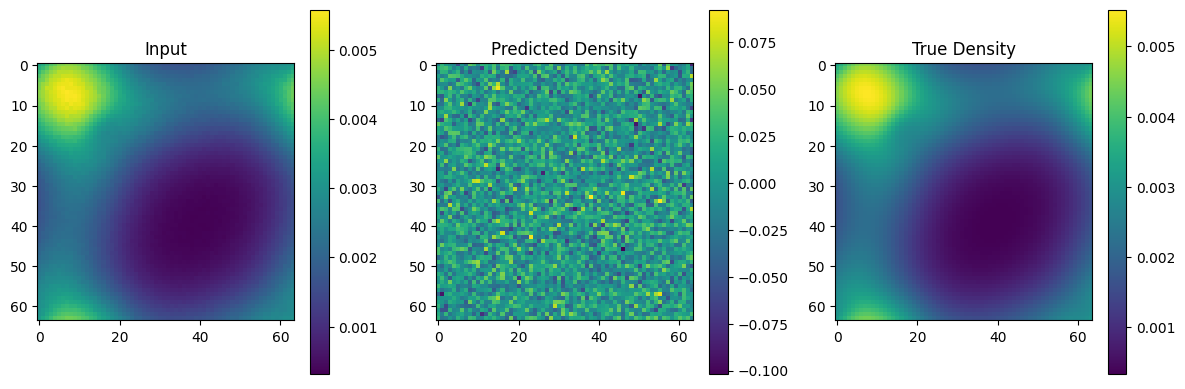

In [20]:
model.eval()
with torch.no_grad():
    i = 0
    x_sample = x_test_t[i:i+1].to(device)
    pred = model(x_sample)[0, 0].cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_test[i, ..., 0], cmap='viridis')
plt.title("Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(pred, cmap='viridis')
plt.title("Predicted Density")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(y_test[i, ..., 0], cmap='viridis')
plt.title("True Density")
plt.colorbar()
plt.tight_layout()
plt.show()
